## Plot DETR log

In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision
from notebook_utils import *

In [2]:
log_directory = [Path('2021-11-15_r50_150ep')]
weight_path = log_directory[0] / Path('best.pth')

In [13]:
# CLASSES = ['No-Object', 'Stenosis']
CLASSES = ['No-Object', 'galaxy', 'source', 'sidelobe']
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556]]
CONFIDENCE_THR = 0.9

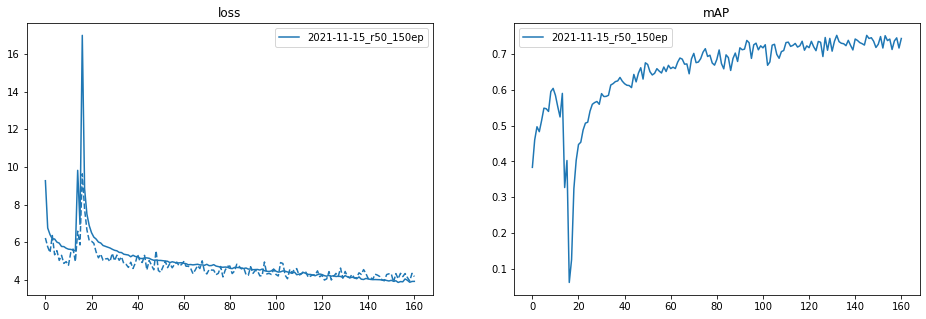

In [4]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

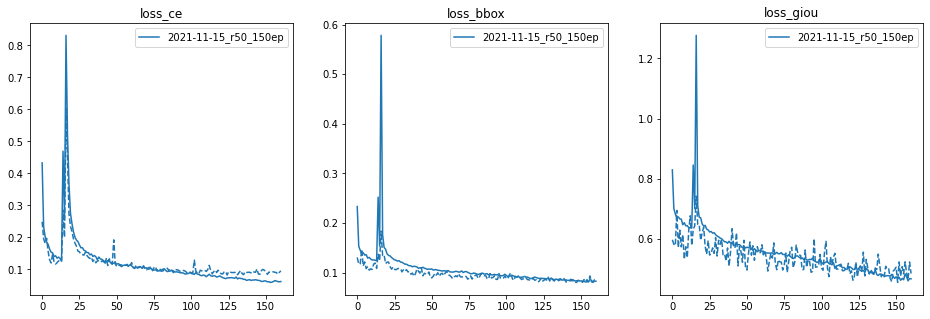

In [5]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

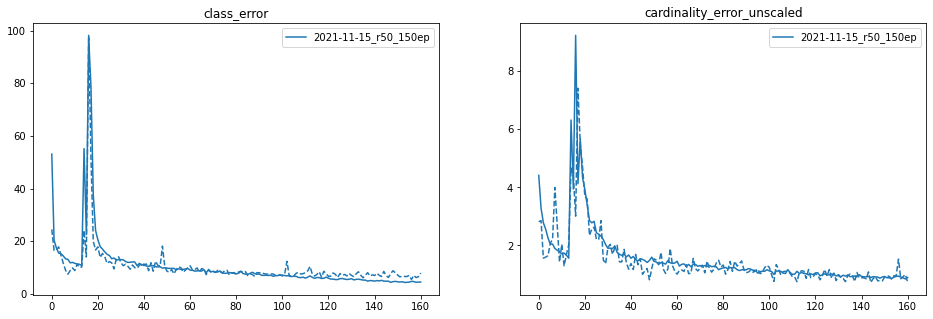

In [6]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the trained model

In [7]:
num_classes= len(CLASSES)

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load(weight_path,
                        map_location='cuda')

# model.query_embed = torch.nn.Embedding(20, 256)

model.load_state_dict(checkpoint['model'],
                      strict=False)

model = model.cuda()
model.eval()

Using cache found in /home/rensortino/.cache/torch/hub/facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

In [8]:
out_box_file = log_directory[0] / Path('rg-boxes.json')
if out_box_file.exists():
    out_box_file.unlink()

## Visualization functions

In [9]:
from PIL import Image
import json
test_dir = Path('data/radio-galaxy/test')

### Run inference on dataset

In [10]:
plt.ioff()
pred_folder_path = Path('predictions')
pred_folder_path.mkdir(exist_ok=True)
out_boxes = {}
batch_idx = 0
for img_path in test_dir.glob('*[.jpeg .png]'):

    img = Image.open(img_path)
    img = apply_transforms(img)

    if img is None:
        print(f'Skipping {img_path}')
        continue
    img = img.unsqueeze(0)
    img = img.cuda()

    outputs = model(img)

    img_name = img_path.stem

    out_boxes[img_name] = {}
    img = img[batch_idx]

    labels, pred_boxes, confidence = format_output(outputs, CONFIDENCE_THR, batch_idx)
    if labels is None or pred_boxes is None or confidence is None:
        out_boxes[img_name]['labels'] = 'None'
        out_boxes[img_name]['boxes'] = 'None'
        out_boxes[img_name]['scores'] = 'None'
        continue
    else:
        bboxes_scaled = rescale_bboxes(pred_boxes, img.shape[1:])
        out_boxes[img_name]['labels'] = [cl_idx for cl_idx in labels.tolist()]
        # out_boxes[img_name]['rel_boxes'] = pred_boxes.tolist()
        out_boxes[img_name]['boxes'] = bboxes_scaled.tolist()
        out_boxes[img_name]['scores'] = confidence.tolist()

with open(out_box_file, 'w') as out_json:
    json.dump(out_boxes, out_json)

/home/rensortino/miniconda3/envs/detr/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/rensortino/miniconda3/envs/detr/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/a

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache() 

## Log single images

In [10]:
def log_image(pil_img, labels, boxes, confidence, title):
    '''
    labels, boxes and confidence are lists
    '''
    fig = plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for cl, (xmin, ymin, xmax, ymax), cs, in zip(labels, boxes, confidence):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=COLORS[cl], linewidth=3))
        text = f'{CLASSES[cl]}: {cs:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    return fig

IndexError: list index out of range

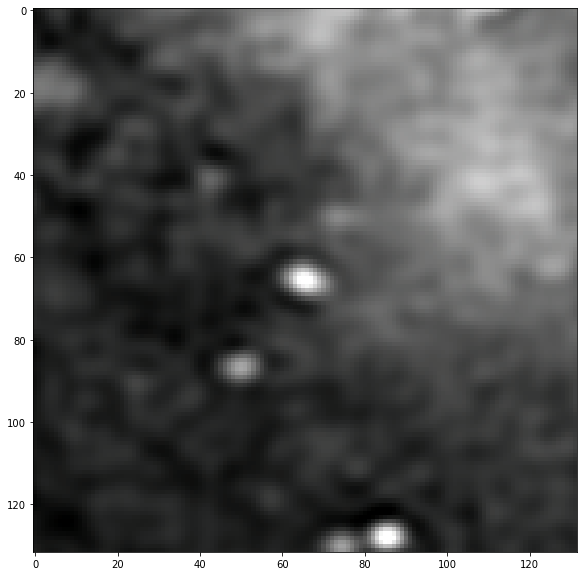

In [17]:
import random
# img_path = Path('data/radio-galaxy/test/sample1_galaxy0002.png')
img_path = random.sample(list(Path('data/radio-galaxy/test').glob('*.png')), 1)[0]

batch_idx = 0

img = Image.open(img_path)
img = apply_transforms(img)

img = img.unsqueeze(0)
img = img.cuda()

outputs = model(img)

labels, pred_boxes, confidence = format_output(outputs, CONFIDENCE_THR)
img = img[batch_idx]

denorm_img = inv_normalize(img)
orig_image = torchvision.transforms.functional.to_pil_image(denorm_img)

# convert boxes from [0; 1] to image scales
try:
    bboxes_scaled = rescale_bboxes(pred_boxes, img.shape[1:])
except:
    print('No prediction')
    fig = log_image(orig_image, labels, bboxes_scaled, confidence, 'Prediction', CLASSES, COLORS)
fig = log_image(orig_image, labels.tolist(), bboxes_scaled.tolist(), confidence.tolist(), 'Prediction')